# Assignment

Chris Andrei Irag, DS4A

October 3, 2025

In [2]:
from collections import deque

import numpy as np
import polars as pl
import seaborn as sns

import matplotlib.pyplot as plt
from src.config import DirectoryPaths
from src.matplotlib import Styles
from sklearn.metrics import root_mean_squared_error

plt.style.use(Styles.CMR10.value)

2025-12-11 21:53:30.824 | INFO     | src.config:<module>:26 - Loaded environment variables from /home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes/.env
2025-12-11 21:53:30.824 | INFO     | src.config:<module>:49 - PROJECT_ROOT: /home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes
2025-12-11 21:53:30.825 | INFO     | src.config:<module>:50 - DATA_DIR: /home/iragca/Documents/github/DS412-Time-Series-Analysis-and-Stochastic-Processes/data
2025-12-11 21:53:30.827 | INFO     | src.matplotlib.color:<module>:103 - Accessible color palette inspired by https://github.com/mpetroff/accessible-color-cycles.


# Load the data

In [3]:
def load_data() -> pl.DataFrame:
    """Load the dataset from a CSV file and preprocess it.

    Returns:
        pl.DataFrame: Preprocessed dataset with 'Date' and 'Earnings Per Share' columns.
    """
    return (
        pl.read_csv(
            DirectoryPaths.EXTERNAL_DATA.value / "jj.csv",
            schema={"date": pl.Date, "value": pl.Float64},
        )
        .with_columns(
            [pl.col("date").alias("Date"), pl.col("value").alias("Earnings Per Share")]
        )
        .select(["Date", "Earnings Per Share"])
    )


dataset = load_data()
dataset

Date,Earnings Per Share
date,f64
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61
…,…
1979-10-01,9.99
1980-01-01,16.2
1980-04-01,14.67


## Splitting the data set

We skip the first element and split data with 0.8/0.2 ration.

In [4]:
def split_data(ratio: float, data: pl.Series) -> tuple[pl.Series, pl.Series]:
    """Split the dataset into training and testing sets based on the given ratio.

    Args:
        ratio (float): The ratio of the training set size to the total dataset size.
        data (pl.Series): The dataset to be split.

    Returns:
        tuple[pl.Series, pl.Series]: A tuple containing the training and testing sets.
    """
    dataset_size = data.len()
    train_size = int(ratio * dataset_size)
                # drop the first element
    train, test = data[1:train_size], data[train_size:]
    return train, test

train, test = split_data(0.8, dataset["Earnings Per Share"])

# Simulating the MA Process

We will use the following equation for the MA process
$$
y_t =0.5Z_{t-1} + 0.4Z_{t-2}
$$

Where 0.5 and 0.4 are the MA coefficients. There are two coefficients, so we will simulate an MA process of order 2.

Text(0, 0.5, 'Value')

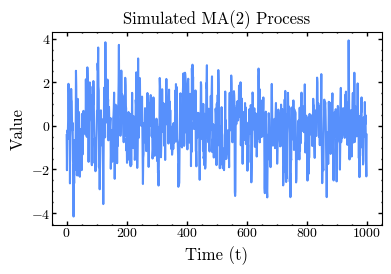

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.graphics.tsaplots import plot_acf

ma_process = ArmaProcess(
    ar=[1, 0, 0],
    ma=[1, 0.5, 0.4],
).generate_sample(1000)

sns.lineplot(ma_process)
plt.title("Simulated MA(2) Process")
plt.xlabel("Time (t)")
plt.ylabel("Value")

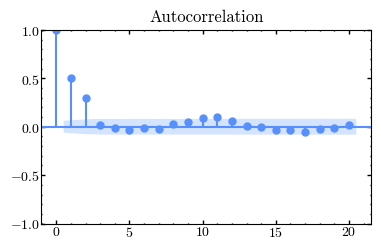

In [10]:
plt.show(plot_acf(ma_process, lags=20))

The MA process can be considered stationary.

In [8]:
ma_model = ARIMA(ma_process, order=(0, 0, 2), enforce_stationarity=False)
ma_model_fit = ma_model.fit()
print(ma_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1416.896
Date:                Thu, 11 Dec 2025   AIC                           2841.791
Time:                        22:00:29   BIC                           2861.410
Sample:                             0   HQIC                          2849.249
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0649      0.060     -1.088      0.276      -0.182       0.052
ma.L1          0.4846      0.030     16.117      0.000       0.426       0.543
ma.L2          0.3895      0.029     13.365      0.0

It can be said the ARIMA model decently reproduced, the AR process coefficients (ma.L1, ma.L2). 

| Fit     | Actual |
|---------|--------|
| 0.4520  | 0.5    |
| 0.3607  | 0.4    |

# Simulating the AR process

This is the equation for the AR process of order 3 we are going to use.
$$
y_t = 0.33y_{t-1} + 0.5y_{t-2} + 0.07y_{t-3}
$$

In [1]:
ar_process = ArmaProcess(
    ar=[1, -0.33, -0.5, -0.07],
    ma=[1, 0, 0, 0],
).generate_sample(1000)

sns.lineplot(ar_process)
plt.title("Simulated AR(3) Process")
plt.xlabel("Time (t)")
plt.ylabel("Value")

NameError: name 'ArmaProcess' is not defined

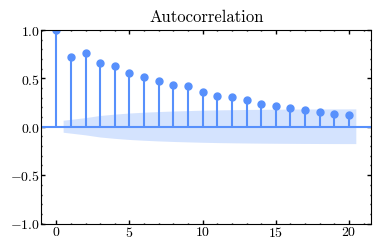

In [8]:
plt.show(plot_acf(ar_process, lags=20))

The AR process is not stationary.

In [9]:
ar_model = ARIMA(ar_process, order=(3, 0, 0), enforce_stationarity=False)
ar_model_fit = ar_model.fit()
print(ar_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -1400.140
Date:                Fri, 31 Oct 2025   AIC                           2810.279
Time:                        08:39:23   BIC                           2834.803
Sample:                             0   HQIC                          2819.601
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0517      0.241     -0.215      0.830      -0.523       0.420
ar.L1          0.3263      0.031     10.441      0.000       0.265       0.388
ar.L2          0.4746      0.030     15.627      0.0

The ARIMA model converges closely to the actual equation.

| Fit     | Actual |
|---------|--------|
| 0.3543  | 0.33   |
| 0.5026  | 0.5    |
| 0.0452  | 0.07   |

# Simulating an ARMA process

Text(0, 0.5, 'Value')

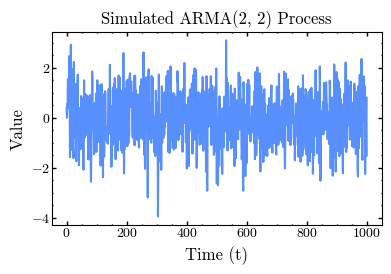

In [10]:
arma_process = ArmaProcess(
    ar=[1, 0.33, 0.5],
    ma=[1, 0.5, 0.4],
).generate_sample(1000)

sns.lineplot(arma_process)
plt.title("Simulated ARMA(2, 2) Process")
plt.xlabel("Time (t)")
plt.ylabel("Value")

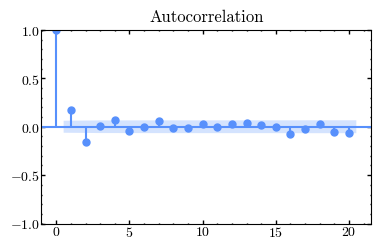

In [11]:
plt.show(plot_acf(arma_process, lags=20))

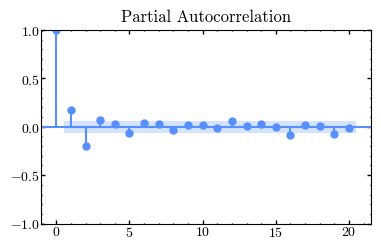

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.show(plot_pacf(arma_process, lags=20))

Both ACF and PACF plots give inconclusive assumptions about the arma process and is harder to simulate due to oscillating auto correlation scores on all lags.

In [13]:
arma_model = ARIMA(arma_process, order=(2, 0, 2), enforce_stationarity=False)
arma_model_fit = arma_model.fit()
print(arma_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1390.809
Date:                Fri, 31 Oct 2025   AIC                           2793.618
Time:                        08:39:23   BIC                           2823.046
Sample:                             0   HQIC                          2804.804
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0345      0.034     -1.001      0.317      -0.102       0.033
ar.L1         -0.6582      0.130     -5.057      0.000      -0.913      -0.403
ar.L2         -0.5667      0.073     -7.755      0.0

| process | coef | Fit     | Actual | 
|---------|------|---------|--------| 
| AR      | l1   | -0.3477 | 0.33   | 
| AR      | l2   | -0.6033 | 0.5    | 
| MA      | l1   | 0.4886  | 0.5    |
| MA      | l2   | 0.4731  | 0.4    |

The ARIMA fails to reproduce the AR coefficients, is close in magnitude but converged on the wrong direction. The data most likely needs to difference using the differencing method.

# Rolling Forecasting Method

We will use the AutoRegression model to fit a set of coefficients, then use those weights indefinitely with Rolling Forecaster for every new data that comes, within a specified window/lag size.

## Fitting

We will use a window size of 12 quarters or 3 years worth of data. 

In [14]:
from statsmodels.tsa.ar_model import AutoReg

WINDOW_SIZE = 12

autoreg = AutoReg(train.to_list(), lags=WINDOW_SIZE)
autoreg_fit = autoreg.fit()
predictions = autoreg_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
autoreg_predictions_series = pl.Series(predictions)

Text(0, 0.5, 'Earnings Per Share')

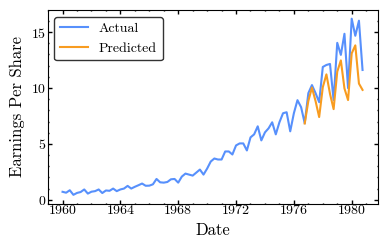

In [15]:
sns.lineplot(x=dataset["Date"], y=dataset["Earnings Per Share"], label="Actual")
sns.lineplot(x=dataset["Date"][-len(test):], y=autoreg_predictions_series, label="Predicted")
plt.xlabel("Date")
plt.ylabel("Earnings Per Share")

In [16]:
autoreg_rmse = root_mean_squared_error(test.to_list(), autoreg_predictions_series.to_list())
autoreg_rmse

2.323408901279477

The Auto Regressor model fits the data well and follows its movements. It has an RMSE score of 2.3.

## Using the RollingForecaster

In combination with the fitted weights/coefficients, we will use 'real-time' data (walk-forward on the test set) to predict the next time step, within the specified window size (12 quarters).

The number of lags, correspond to the window size because each lag has its own weight/coefficient, and we can only work with those said weights/coefficients so it is implied that:

$$
 l = k = w
$$

where
- $l$ = number of lags
- $k$ = number of coefficients
- $w$ = window size

So to predict the next time step

we simply do a dot product of the latest data bounded by the window and the lag coefficients, plus some bias.

$$
\hat{x}_{t+1} = dot(\mathbf{x} \in \mathbb{R}^{w}, \beta \in \mathbb{R}^{k}) + b
$$

Where
- $\mathbf{x}$ is the array of the latest data from $t$ until $t-l$
- $\hat{x}_{t+1}$ is the prediction of what might be the next time step value, which is a scalar.
- $b$ is the intercept/bias, also a scalar.

Since this is a rolling process, we update the data with latest observation data. This is represented as a queue-like data structure, where each new data is added to the front, and the oldest one is removed.

In [17]:
from typing import Union


class RollingForecaster:
    """
    Rolling linear forecaster using fixed coefficients.

    This class maintains a sliding window of recent time series values
    and computes 1-step-ahead forecasts using a dot product of the
    stored data and precomputed coefficients plus a bias term.

    Parameters
    ----------
    coefficients : list or numpy.ndarray
        Coefficients for the forecast model, ordered from oldest lag
        to the most recent (e.g., ``[coef(t-2), coef(t-1), coef(t)]``).

    data : list, numpy.ndarray, or polars.Series
        Initial window of past observations, ordered from oldest to most
        recent (e.g., ``[x(t-2), x(t-1), x(t)]``). The length must match
        the number of coefficients.
    
    bias : int, optional
        Intercept term added to the dot product, by default 0.

    Notes
    -----
    - If `data` is shorter than the number of `coefficients`, calling
      ``forecast()`` will raise an error.
    - Internally, data is stored in a deque with a fixed maximum length
      equal to the number of coefficients.
    """

    def __init__(
        self,
        coefficients: Union[list, np.ndarray],
        data: Union[list, np.ndarray, pl.Series],
        bias: int = 0
    ):
        """
        Initialize the rolling forecaster.

        Parameters
        ----------
        coefficients : list or numpy.ndarray
            Coefficients for the forecast model, ordered from oldest lag
            to the most recent (e.g., ``[coef(t-2), coef(t-1), coef(t)]``).
        data : list, numpy.ndarray, or polars.Series
            Initial window of past observations, ordered from oldest to most
            recent (e.g., ``[x(t-2), x(t-1), x(t)]``). The length must match
            the number of coefficients.
        bias : int, optional
            Intercept term added to the dot product, by default 0.

        Raises
        ------
        ValueError
            If the rolling window does not yet contain enough values
            to match the number of coefficients.

        Notes
        -----
        Given time step ``t`` and the next forecast (to predict) step ``t+1``:

        The forecast is computed as:

        ``forecast(t+1) = dot(coefficients, data) + bias``

        where:
            - ``data`` is the rolling window of observations ``[x(t-lag), ..., x(t)]``
            - ``coefficients`` are aligned in the same order
            - ``bias`` is the intercept term

        Example
        -------
        If::

            data = [x(t-2), x(t-1), x(t)]
            coefficients = [coef(t-2), coef(t-1), coef(t)]

        then::

            forecast() = x(t+1) = coef(t-2)*x(t-2) + coef(t-1)*x(t-1) + coef(t)*x(t) + bias
        """
        if isinstance(data, list):
            data = np.array(data, dtype=float)
        elif isinstance(data, pl.Series):
            data = data.to_numpy()

        if isinstance(coefficients, list):
            coefficients = np.array(coefficients)

        self.window_size = len(coefficients)
        if self.window_size != len(data):
            raise ValueError(
                f"Not enough data to make a forecast. "
                f"Coefficients length: {self.window_size}, "
                f"Data length: {len(self.data)}")

        self.data = deque(data, maxlen=self.window_size)
        self.coefficients = coefficients
        self.bias = bias

    def update_data(self, latest_value: float):
        """
        Append a new observation to the rolling window.

        Parameters
        ----------
        latest_value : float
            The most recent time series value x(t+1).
        """
        self.data.append(latest_value)

    def forecast(self) -> float:
        """
        Compute the forecast using the current window.

        Returns
        -------
        float
            The 1-step-ahead forecast value:
            ``dot(coefficients, data_window) + bias``.
        """
        return float(np.dot(self.coefficients, self.data) + self.bias)

In [18]:
bias, *coefs = autoreg_fit.params

forecaster = RollingForecaster(
    coefficients=coefs[::-1], 
    data=train[-len(coefs):], 
    bias=bias
    )

predictions = []
for actual_obs in test:
    prediction = forecaster.forecast()
    predictions.append(prediction)
    forecaster.update_data(actual_obs)

predictions_series = pl.Series(predictions)
predictions_series

""
f64
6.82333
8.851993
10.285858
8.945962
7.720722
…
11.220975
15.785415
15.256569


In [19]:
rmse = root_mean_squared_error(test.to_list(), predictions_series.to_list())
rmse

0.9816179637715994

Text(0.5, 1.0, 'Rolling Forecast vs Actual Observations')

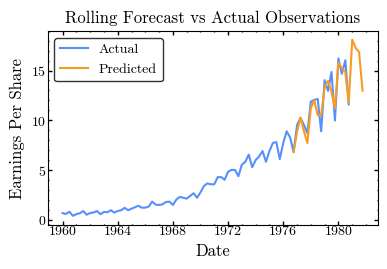

In [20]:
new_predictions = predictions.copy()

# Perform recursive forecasting for 4 additional quarters
for quarter in range(4):
    prediction = forecaster.forecast()
    new_predictions.append(prediction)
    forecaster.update_data(prediction)

new_dates = pl.date_range(
    start=dataset["Date"][-len(test)],
    end=dataset["Date"][-1] + pl.duration(days=90 * 5),
    interval="3mo",
    eager=True
)

sns.lineplot(x=dataset["Date"], y=dataset["Earnings Per Share"], label="Actual")
sns.lineplot(x=new_dates, y=new_predictions, label="Predicted")
plt.xlabel("Date")
plt.ylabel("Earnings Per Share")
plt.title("Rolling Forecast vs Actual Observations")

The rolling forecaster does a better job with an RMSE score of `0.981`. The performance was enhanced by augmenting the data with real-time data.